# 통신사 고객 이탈 예측

## 프로젝트 목표
- 통신사 고객 이탈(Churn)을 사전에 예측하고, 이탈 가능 고객을 선제적으로 관리하기 위한 분석을 수행

## 분석 방향
- Logistic Regression과 Random Forest 모델을 비교한다.

## 1. 문제 정의 및 데이터 이해

In [254]:

# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
train = pd.read_csv("churn-bigml-80.csv")
test  = pd.read_csv("churn-bigml-20.csv")

# 데이터 개수 및 변수 개수 확인
print("Train :", train.shape)
print("Test :", test.shape)

train.head()

Train : (2666, 20)
Test : (667, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 데이터 정리
    "State": "주",
    "Account length": "가입 기간",
    "Area code": "지역 코드",
    "International plan": "국제전화 요금제",
    "Voice mail plan": "음성사서함 요금제",
    "Total day minutes": "주간 통화 시간",
    "Total day charge": "주간 통화 요금",
    "Customer service calls": "고객센터 문의 횟수",
    "Churn": "고객 이탈 여부"

In [271]:
# 타겟 변수(Churn) 확인
train["Churn"].value_counts()
train["Churn"].value_counts(normalize=True)

Churn
False    0.854464
True     0.145536
Name: proportion, dtype: float64

## 2. 데이터 전처리

In [273]:
# 결측치 제거
train = train.dropna()
test  = test.dropna()

# 결측치 확인
print("train shape:", train.shape)
print("test shape :", test.shape)

print("train 결측치 존재?", train.isnull().values.any())
print("test  결측치 존재?", test.isnull().values.any())

train shape: (2666, 20)
test shape : (667, 20)
train 결측치 존재? False
test  결측치 존재? False


International plan, Voice mail plan, Churn 변수를
Yes/No, True/False 형태에서 0/1로 변환한다.

In [274]:
# 범주형 변수 인코딩(이진 변수)
for df in [train, test]:
    # 설명 변수 (범주형)
    df["International plan"] = df["International plan"].map({"Yes": 1, "No": 0})
    df["Voice mail plan"]    = df["Voice mail plan"].map({"Yes": 1, "No": 0})
    # 타겟 변수 (Churn)
    df["Churn"] = df["Churn"].map({True: 1, False: 0})

# 자동 범주형 변수 인코딩
categorical_cols = train.select_dtypes(include=["object"]).columns
train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test  = pd.get_dummies(test,  columns=categorical_cols, drop_first=True)

# 인코딩 결과 확인
train.head()
train.dtypes

Account length           int64
Area code                int64
International plan       int64
Voice mail plan          int64
Number vmail messages    int64
                         ...  
State_VT                  bool
State_WA                  bool
State_WI                  bool
State_WV                  bool
State_WY                  bool
Length: 69, dtype: object

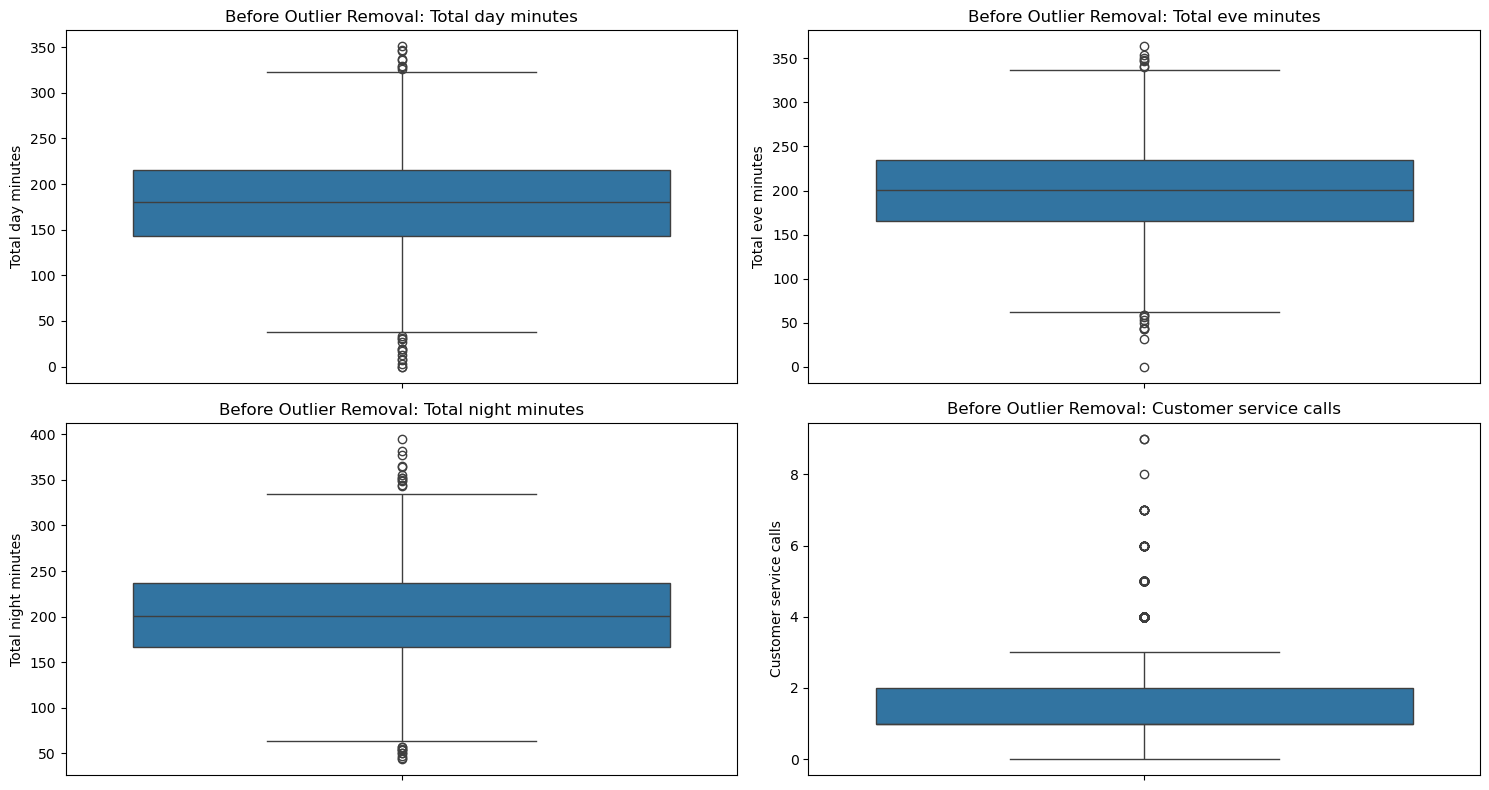

In [175]:

# 이상치 제거 함수 정의 (IQR 방식)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    condition = (df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)
    return df.loc[~condition].copy()

# 이상치 제거 전 분포 확인(Boxplot)
plt.figure(figsize=(15, 8))

for i, col in enumerate([
    "Total day minutes",
    "Total eve minutes",
    "Total night minutes",
    "Customer service calls"
], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train[col])
    plt.title(f"Before Outlier Removal: {col}")

plt.tight_layout()
plt.show()

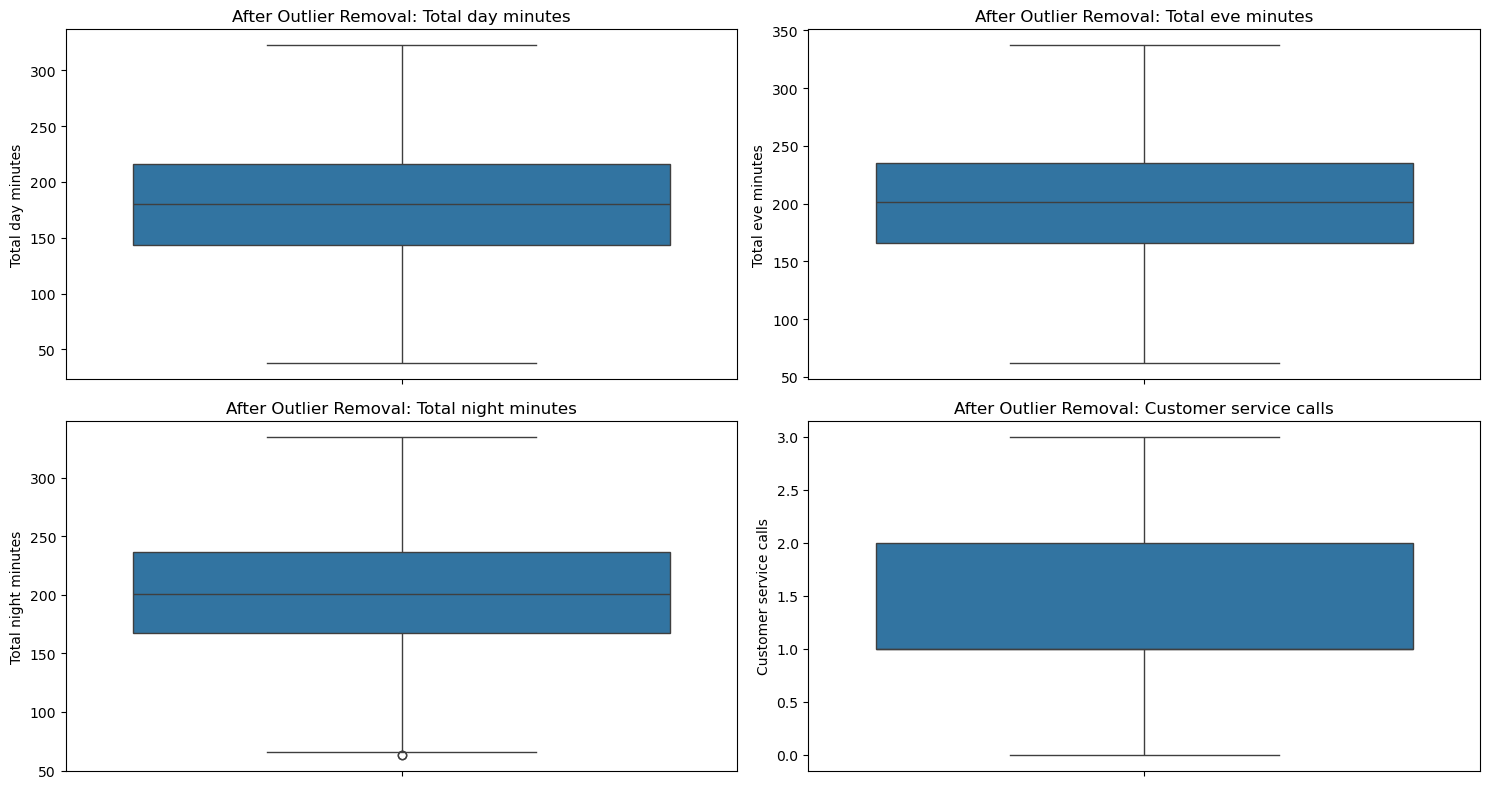

In [176]:
# 이상치 제거
for col in [
    "Total day minutes",
    "Total eve minutes",
    "Total night minutes",
    "Customer service calls"
]:
    train = remove_outliers(train, col)

# 이상치 제거 후 분포 확인
plt.figure(figsize=(15, 8))

for i, col in enumerate([
    "Total day minutes",
    "Total eve minutes",
    "Total night minutes",
    "Customer service calls"
], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=train[col])
    plt.title(f"After Outlier Removal: {col}")

plt.tight_layout()
plt.show()

In [258]:
# 전처리 후 데이터 크기 확인

print("훈련 데이터 크기:", len(train))
print("테스트 데이터 크기:", len(test))

훈련 데이터 크기: 2666
테스트 데이터 크기: 667


## 3. EDA

### 단변량 분석 - 수치형 변수 분포

수치형 변수의 분포를 확인하여
전반적인 데이터 특성과 이상치 여부를 탐색한다.

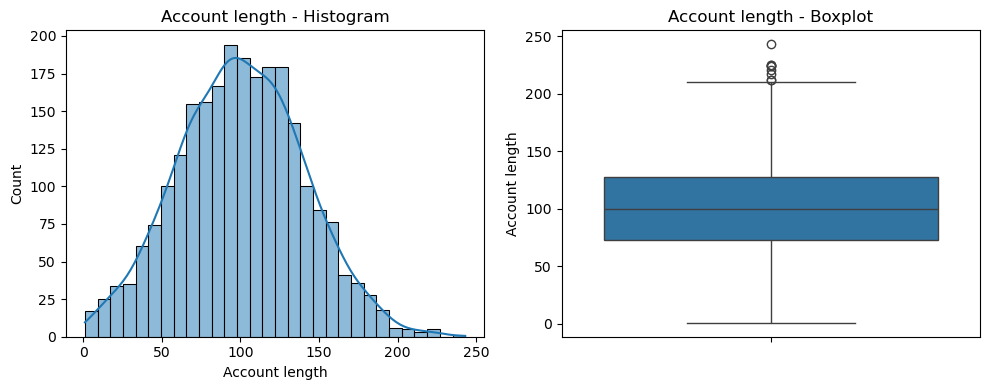

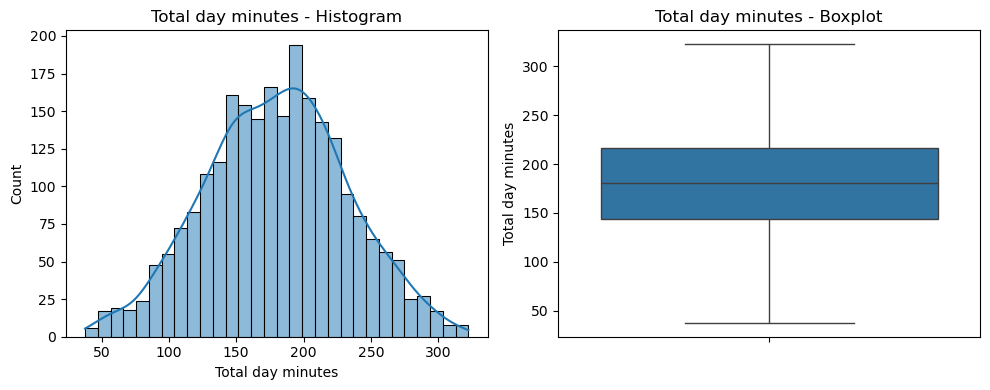

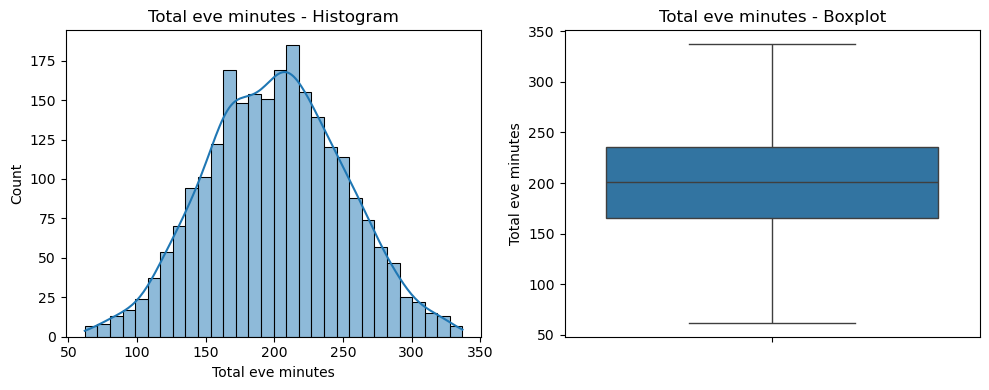

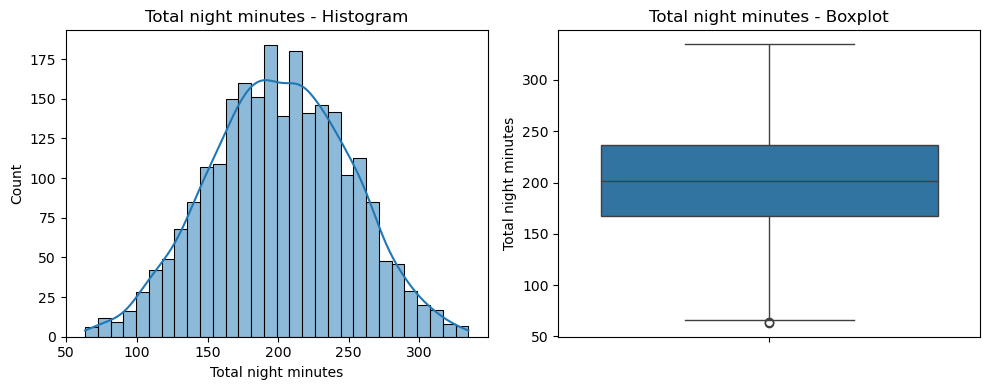

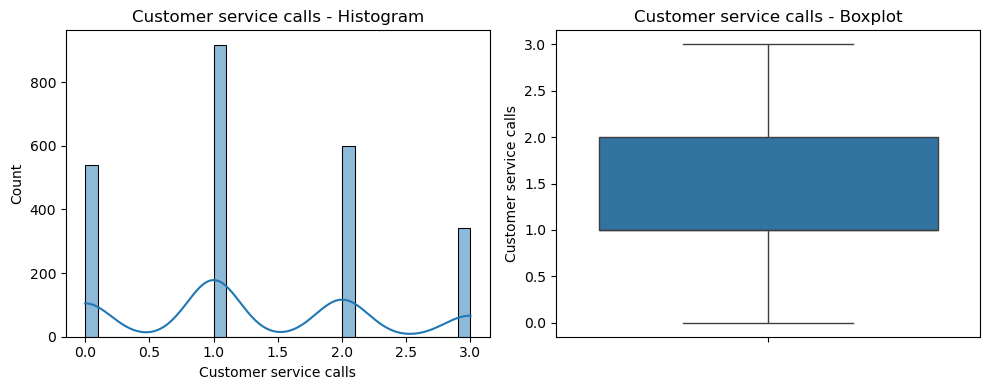

In [178]:

# 수치형 변수
num_vars = [
    "Account length",
    "Total day minutes",
    "Total eve minutes",
    "Total night minutes",
    "Customer service calls"
]

# 분포 확인
for col in num_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # 히스토그램
    sns.histplot(train[col], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} - Histogram")
    
    # 박스플롯
    sns.boxplot(y=train[col], ax=axes[1])
    axes[1].set_title(f"{col} - Boxplot")
    
    plt.tight_layout()
    plt.show()

### 단변량 분석 - 범주형 변수 분포


=== Account length 빈도표 ===
Account length
93     35
105    33
87     33
101    32
99     32
       ..
186     1
6       1
195     1
243     1
221     1
Name: count, Length: 205, dtype: int64

=== Area code 빈도표 ===
Area code
415    1318
510     679
408     669
Name: count, dtype: int64

=== International plan 빈도표 ===
International plan
0    2396
1     270
Name: count, dtype: int64

=== Voice mail plan 빈도표 ===
Voice mail plan
0    1933
1     733
Name: count, dtype: int64

=== Number vmail messages 빈도표 ===
Number vmail messages
0     1933
31      50
28      42
29      39
24      37
33      37
30      35
27      34
25      33
32      33
26      32
23      30
37      25
22      24
35      24
34      23
36      23
38      22
39      22
21      22
20      14
19      14
42      13
40      13
17      12
16      11
43       9
15       8
44       7
41       7
18       6
12       6
14       5
45       4
46       3
47       3
13       3
8        2
50       2
9        2
4        1
10       1
Name: 

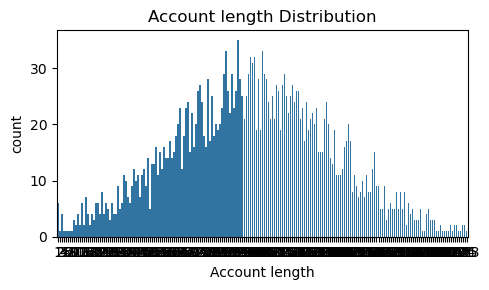

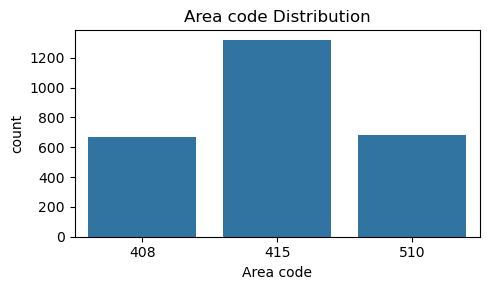

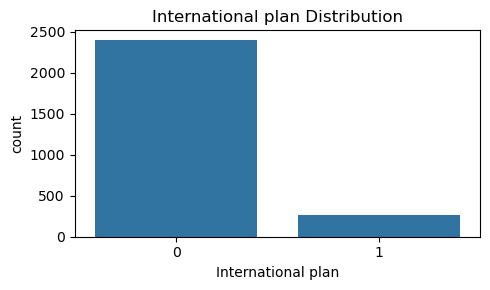

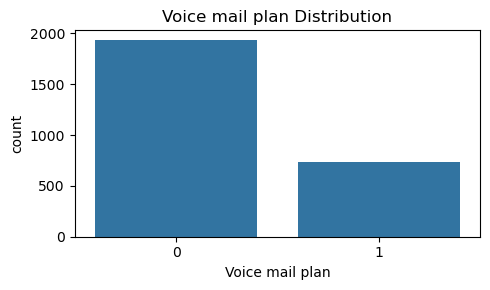

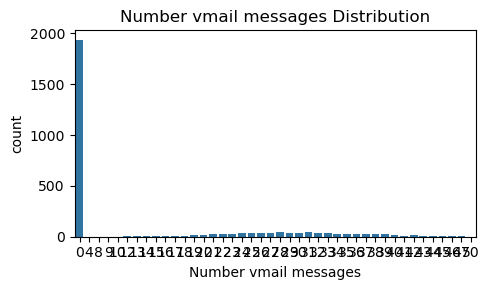

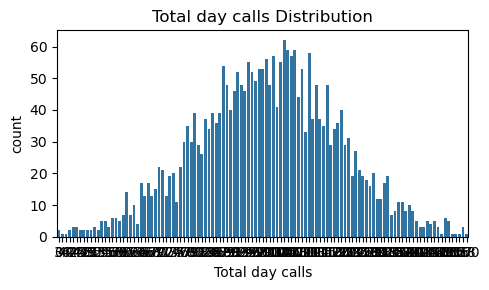

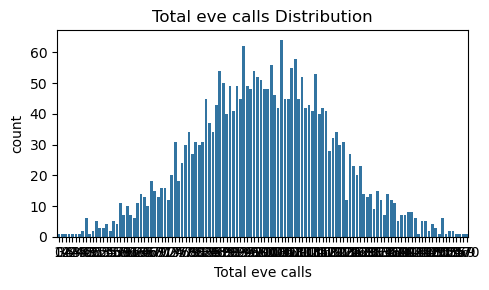

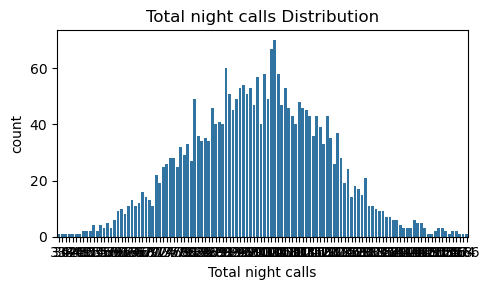

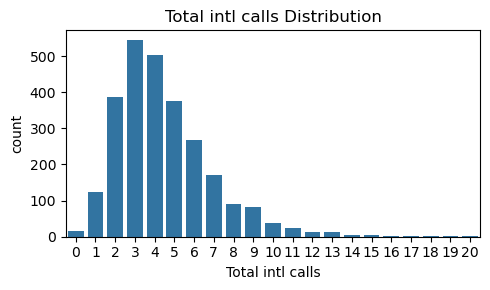

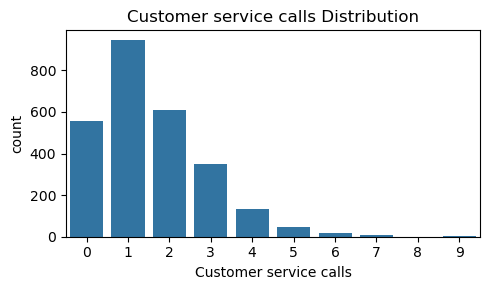

In [280]:
# 범주형 변수
cat_vars = train.select_dtypes(include=["object", "int64"]).columns.tolist()

# 타겟 변수는 제외
cat_vars.remove("Churn")
cat_vars

# 빈도표
for col in cat_vars:
    print(f"\n=== {col} 빈도표 ===")
    print(train[col].value_counts())

# 막대그래프
for col in cat_vars:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=col, data=train)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


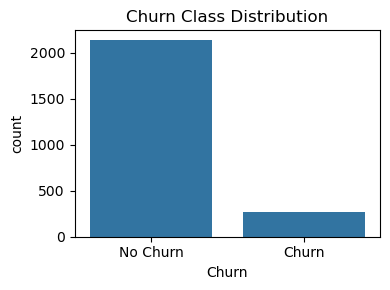

In [181]:
# 개수 기준
churn_count = train["Churn"].value_counts()
churn_count

# 비율 기준
churn_ratio = train["Churn"].value_counts(normalize=True) * 100
churn_ratio.round(2)

# 막대 그래프로 시각화
plt.figure(figsize=(4, 3))
sns.countplot(x="Churn", data=train)
plt.title("Churn Class Distribution")
plt.xticks([0, 1], ["No Churn", "Churn"])
plt.tight_layout()
plt.show()

범주형 변수에 대한 단변량 분석 결과,
일부 변수는 특정 범주에 관측치가 집중된 분포를 보였다.
또한 타겟 변수인 Churn은 비이탈 고객의 비중이 상대적으로 높아
클래스 불균형이 존재함을 확인하였다.
이는 이후 모델링 단계에서 고려될 필요가 있다.

### 상관관계 분석

수치형 변수 간 상관관계를 확인하고, Churn과 연관성이 높은 변수를 탐색한다.

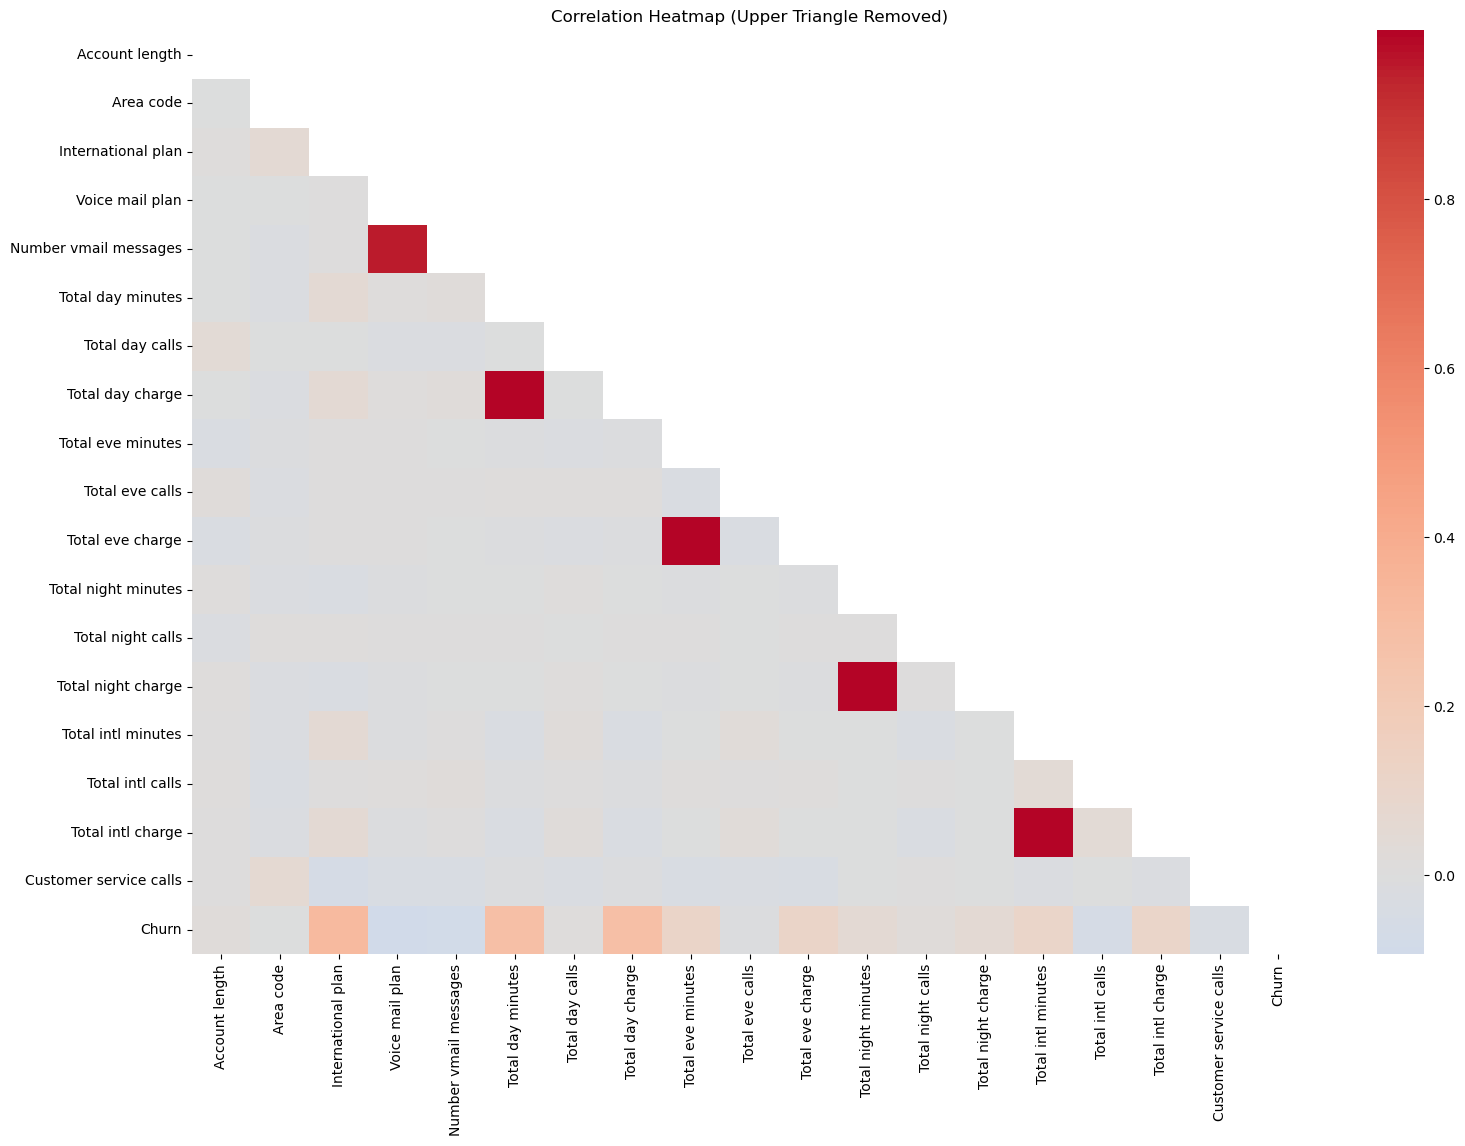

In [182]:
# 수치형 변수만 선택
numeric_df = train.select_dtypes(include=[np.number])

# 상관계수 계산
corr = numeric_df.corr()

# 상관계수 히트맵 시각화
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18, 12))
sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Upper Triangle Removed)")
plt.show()

In [218]:
# churn 기준으로 해석
corr["Churn"].sort_values(ascending=False)

Churn                     1.000000
International plan        0.320174
Total day minutes         0.288109
Total day charge          0.288107
Total eve minutes         0.112826
Total eve charge          0.112824
Total intl charge         0.104216
Total intl minutes        0.104150
Total night minutes       0.051929
Total night charge        0.051905
Account length            0.024802
Total night calls         0.021216
Total day calls           0.011749
Area code                -0.005080
Total eve calls          -0.011888
Customer service calls   -0.030278
Total intl calls         -0.056677
Number vmail messages    -0.080462
Voice mail plan          -0.093455
Name: Churn, dtype: float64

상관관계 분석 결과, International plan, Total day minutes,
Total day charge 변수는 Churn과 상대적으로 높은 상관관계를 보였다.

Total day minutes, Total day charge 변수를 T-test 진행

목적 : Churn 여부에 따라 주간 통화량과 주간 요금의 평균이 유의미하게 다른지 확인

In [279]:
# 이탈 / 비이탈 고객 그룹 분리

churn_yes = train[train["Churn"] == 1]
churn_no  = train[train["Churn"] == 0]

# t-test 대상 변수
vars_to_test = [
    "Total day minutes",
    "Total day charge"
]

# 두 집단 평균 차이 검정
# 귀무가설(H₀): 이탈 고객과 비이탈 고객의 평균 사용량은 같다
# 대립가설(H₁): 두 집단의 평균 사용량은 다르다

# 변수별 t-test 수행
for col in vars_to_test:
    t_stat, p_val = stats.ttest_ind(
        churn_yes[col],
        churn_no[col]
    )
    print(f"[{col}]")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value    : {p_val:.3e}\n")

[Total day minutes]
  t-statistic: 10.299
  p-value    : 2.023e-24

[Total day charge]
  t-statistic: 10.299
  p-value    : 2.022e-24



t-test 결과
독립표본 t-test 결과,
이탈 고객과 비이탈 고객 간의 평균 차이에 대한
귀무가설을 기각할 수 있었으며,
두 집단 간에는 통계적으로 유의미한 차이가 존재함을 확인하였다.

해석..
이탈 고객은 비이탈 고객과 다른 패턴을 사용?
요금 부담 혹은 요금 인식 차이가 이탈과 연관?

International plan 가입 여부와 Churn 간의 관계가
통계적으로 유의미한지 확인하기 위해
카이제곱 독립성 검정을 수행한다.

In [282]:
# 교차표 생성
ct = pd.crosstab(
    train["International plan"],
    train["Churn"]
)

ct

# 카이제곱 검정 수행
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square statistic:", chi2)
print("p-value:", p)

Chi-square statistic: 202.682107174188
p-value: 5.426940549114707e-46


- 귀무가설(H0): International plan과 Churn은 서로 독립이다.
- p-value가 0.05보다 작아 귀무가설을 기각할 수 있다.
- International plan 가입 여부는 Churn과 통계적으로 유의미한 관계를 가진다.

### 이변량 분석 - International Plan

International plan 가입 여부에 따른 Churn 비율을 비교한다.

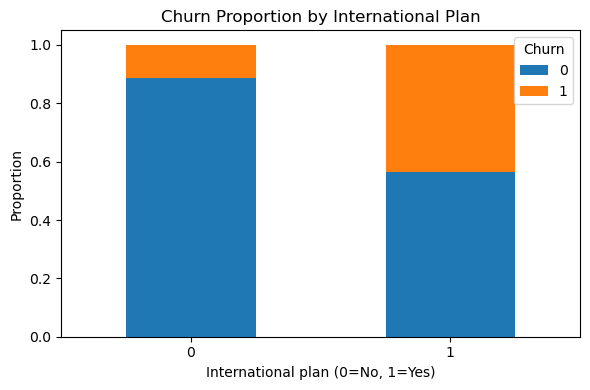

In [281]:
# International plan 와 Churn의 이변량 분석

# 교차표 (비율 기준)
ct_rate = pd.crosstab(
    train["International plan"],
    train["Churn"],
    normalize="index"
)
# 스택 바 차트
ax = ct_rate.plot(
    kind="bar",
    stacked=True,
    figsize=(6, 4)
)

ax.set_title("Churn Proportion by International Plan")
ax.set_xlabel("International plan (0=No, 1=Yes)")
ax.set_ylabel("Proportion")
ax.legend(title="Churn", loc="upper right")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

International plan 가입 여부에 따른 이탈률을 비교한 결과,
가입 고객과 미가입 고객 간 이탈 비율에 차이가 관찰되었다.
이는 International plan이 이탈 위험군을 구분하는 데
유용한 범주형 변수일 가능성을 시사한다.

In [278]:
# 유의미한 세 변수의 다중공선성 계산

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_vars = [
    "International plan",
    "Total day minutes",
    "Total day charge"
]

X = train[vif_vars]

vif_df = pd.DataFrame()
vif_df["변수"] = X.columns
vif_df["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

vif_df.sort_values("VIF", ascending=False)

,변수,VIF
2,Total day charge,1.236945e+08
1,Total day minutes,1.236943e+08
0,International plan,1.113172e+00


결과 Total day charge랑 Total day minutes는 거의 동일한 정보 & International plan은 독립
=> Total day charge랑 Total day minute는 같이 사용 불가, 비즈니스 관점에서 Total day charge는 제거하고 사용량 기준으로 봄

국제 통화 서비스 사용보다 실제 국제 통화 사용량이 이탈과 관련이 있을까?

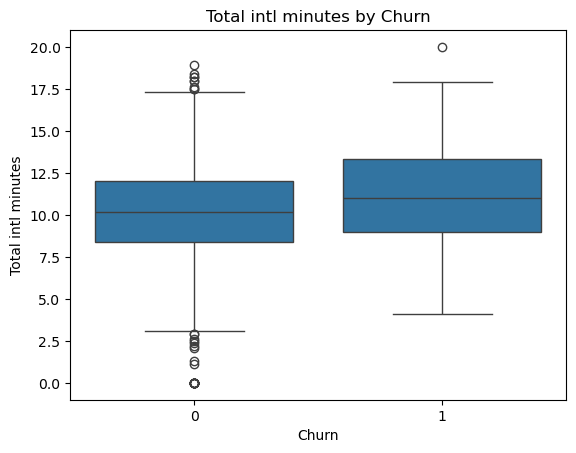

In [ ]:
sns.boxplot(x="Churn", y="Total intl minutes", data=train)
plt.title("Total intl minutes by Churn")
plt.show()

국제 통화 사용량(Total intl minutes)에 대해 이탈 여부에 따른 분포를 비교한 결과,
이탈 고객과 비이탈 고객 간 사용 패턴 차이가 관찰되었다.
이는 국제 통화 사용 행태가 이탈 위험을 구분하는 데
추가적인 정보를 제공할 가능성을 시사한다.

### 이변량 분석 - Total day minutes

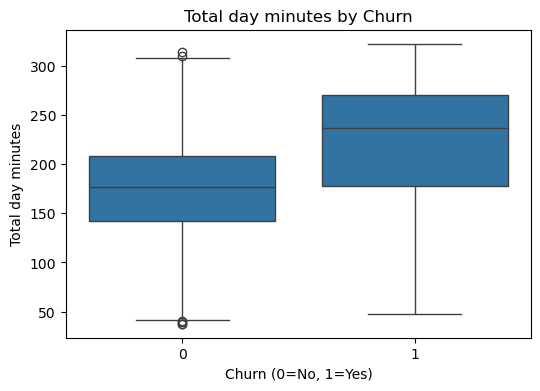

In [187]:
# Total day minutes 와 Churn의 이변량분석
plt.figure(figsize=(6,4))
sns.boxplot(
    x="Churn",
    y="Total day minutes",
    data=train
)
plt.title("Total day minutes by Churn")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.show()

수치형 변수인 Total day minutes에 대해 이탈 여부에 따른 분포를 비교한 결과,
이탈 고객과 비이탈 고객 간 주간 통화 사용량 분포에 차이가 관찰되었다.
이는 Total day minutes가 이탈 위험군을 구분하는 데
활용 가능한 수치형 변수일 가능성을 시사한다.

### 이변량 분석 - Customer service calls

<Axes: xlabel='Churn', ylabel='Customer service calls'>

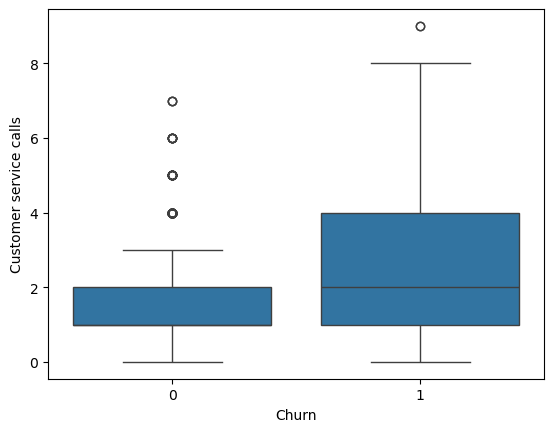

In [ ]:
# Customer service calls와 Churn
sns.boxplot(x="Churn", y="Customer service calls", data=train)

Customer service calls 분석 결과, 이탈 고객의 고객센터 문의 횟수가 비이탈 고객 그룹보다 높게 나타난다.

## 4. 비즈니스 가설 도출
1. 고객센터 문의가 누적될수록 이탈 가능성이 높아진다.
2. International Plan 가입 고객은 구조적으로 이탈 위험이 높다.
3. 통화 사용량이 많은 고객일수록 이탈 위험이 높다.

## 5. 모델링 학습, 평가 및 해석

앞선 EDA를 통해 도출한 비즈니스 가설을
모델 학습을 통해 검증한다.

모델의 목적은 단순 예측 정확도가 아니라,
- 어떤 변수가 이탈 예측에 기여하는지
- 이탈 고객을 얼마나 잘 탐지하는지
를 확인하는 것이다.

### Feature 선택 및 데이터 분리
EDA 결과를 바탕으로 이탈과 직접적인 관련이 있다고 판단되는 변수만 선택하여 모델 학습을 진행한다.
- International plan : 국제요금제 가입 여부
- Total day minutes : 하루 통화 사용량
- Total intl minutes : 국제 통화 사용량
- Customer service calls : 고객센터 문의 횟수

In [285]:
# 모델에 사용 할 변수
features = [
    "International plan",
    "Total day minutes",
    "Total intl minutes",
    "Customer service calls"
]
# 데이터 분리
X = train[features]
y = train["Churn"]

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Logistic Regression 모델 학습

In [295]:
# 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# 모델 성능 평가
from sklearn.metrics import classification_report

y_pred = log_model.predict(X_valid)
print(classification_report(y_valid, y_pred))

# 계수 확인 및 해석
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": log_model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df

              precision    recall  f1-score   support

           0       0.86      0.95      0.91       456
           1       0.31      0.13      0.18        78

    accuracy                           0.83       534
   macro avg       0.59      0.54      0.54       534
weighted avg       0.78      0.83      0.80       534



,feature,coefficient
0,International plan,2.154542
3,Customer service calls,0.530812
2,Total intl minutes,0.096880
1,Total day minutes,0.012757


국제 요금제 가입 여부는 다른 변수들을 통제한 상태에서도 이탈 확률을 크게 증가시키는 핵심 요인으로 확인.

### 모델 평가 지표 계산

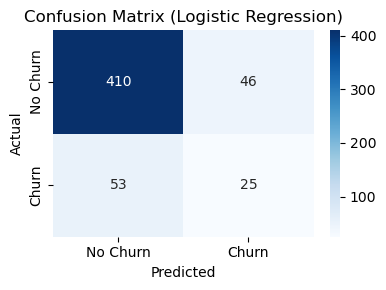

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       456
           1       0.35      0.32      0.34        78

    accuracy                           0.81       534
   macro avg       0.62      0.61      0.61       534
weighted avg       0.81      0.81      0.81       534



In [301]:
# confusion matrix
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()

print(classification_report(y_valid, y_pred))

False Negative가 40명 / 이탈했는데, 이탈 안 할 거라고 판단
False positive가 9명 / 이탈 안 했는데 이탈 했다고 판단
=> 임계점을 조절해야함
False Negative가 False Positive보다 크다

Churn 데이터의 불균형을 고려하여, 이탈 고객을 놓치지 않기 위해 threshold를 0.3으로 설정한다.

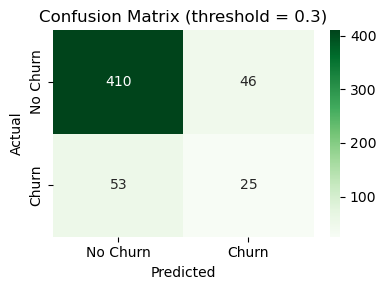

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       456
           1       0.35      0.32      0.34        78

    accuracy                           0.81       534
   macro avg       0.62      0.61      0.61       534
weighted avg       0.81      0.81      0.81       534



In [302]:
# 1. 예측 확률 계산 (Churn=1)
y_prob = log_model.predict_proba(X_valid)[:, 1]

# 2. threshold 재설정
threshold = 0.3
y_pred = (y_prob >= threshold).astype(int)

# 3. Confusion Matrix 출력

cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.tight_layout()
plt.show()

# 4. 평가 지표 출력
print(classification_report(y_valid, y_pred))

In [306]:
# Accuracy/Recall/F1-score 출력
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

print("Accuracy :", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall   :", recall_score(y_valid, y_pred))
print("F1-score :", f1_score(y_valid, y_pred))

Accuracy : 0.8146067415730337
Precision: 0.352112676056338
Recall   : 0.32051282051282054
F1-score : 0.33557046979865773


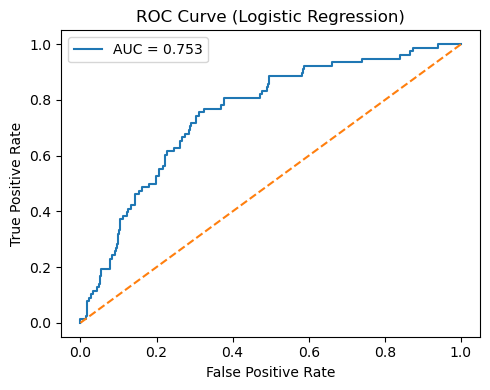

In [307]:
# ROC Curve & AUC
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_valid, y_prob)
auc_score = roc_auc_score(y_valid, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()

이탈 고객과 비이탈 고객을 잘 구분

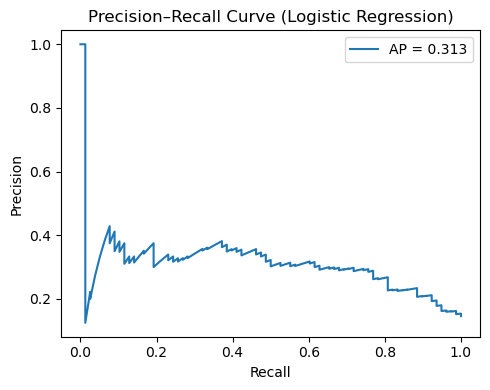

In [308]:
# Precision–Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, _ = precision_recall_curve(y_valid, y_prob)
ap_score = average_precision_score(y_valid, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(recall_vals, precision_vals, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()

### Random Forest 모델 학습
비선형 관계를 반영하기 위해 Random Forest 모델을 학습한다.

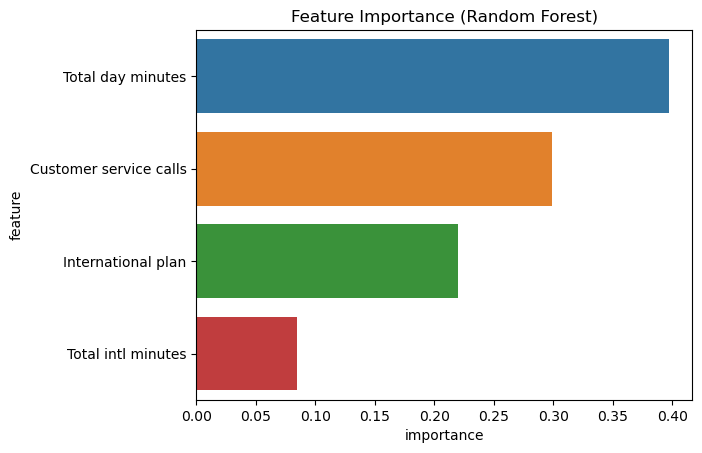

,feature,importance
1,Total day minutes,0.396748
3,Customer service calls,0.298824
0,International plan,0.219547
2,Total intl minutes,0.084881


In [311]:
# Random Forest 학습
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train, y_train)

# Feature Importance 확인
rf_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# 시각화
sns.barplot(
    data=rf_importance,
    x="importance",
    y="feature",
    hue="feature",
    legend=False
)
plt.title("Feature Importance (Random Forest)")
plt.show()

rf_importance

### 모델 해석 1: Feature Importance

In [ ]:
Random Forest는 선형 계수(coef)가 없기 때문에,
각 변수가 예측에 얼마나 기여했는지를 feature_importances_로 확인한다.

- 목적: 어떤 요인이 이탈 예측에 가장 크게 기여하는지 파악
- 활용: 이후 비즈니스 인사이트/액션 플랜의 근거로 사용

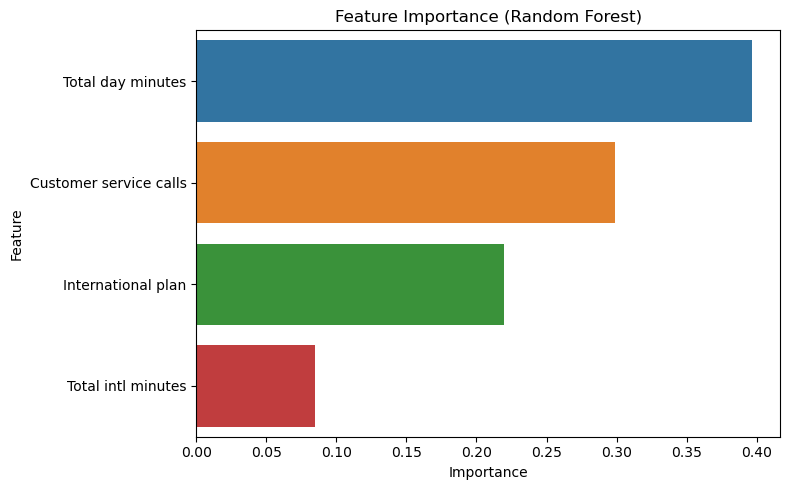

In [317]:
# Feature importance 추출
rf_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importance

# Feature importance 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    data=rf_importance,
    x="importance",
    y="feature",
    hue="feature",   # seaborn 경고 방지
    legend=False
)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 모델 해석 2: PDP
Feature importance는 '무엇이 중요한지'를 알려주지만,
PDP는 '그 변수가 커질수록 이탈 확률이 어떻게 변하는지'를 보여준다.

- 목적: 비선형 관계/임계점(예: 3회 이상부터 급증)을 시각적으로 확인
- 활용: "몇 이상이면 위험" 같은 운영 기준(룰/정책)으로 연결 가능

/opt/homebrew/anaconda3/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.13/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


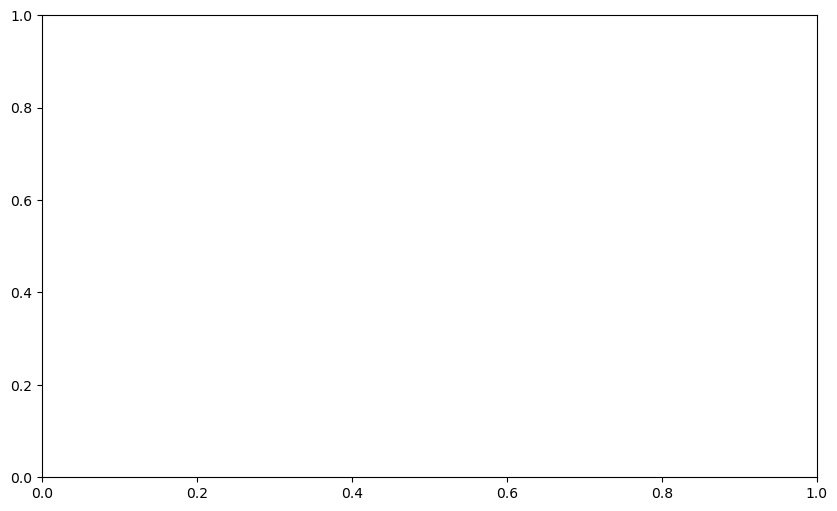

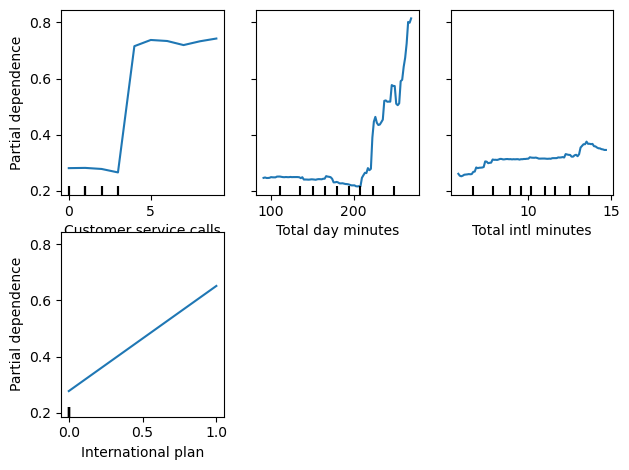

In [319]:
from sklearn.inspection import PartialDependenceDisplay
# PDP 대상 변수 (너가 인사이트로 쓰는 핵심 변수 위주로)
pdp_features = [
    "Customer service calls",
    "Total day minutes",
    "Total intl minutes",
    "International plan"
]

# PartialDependenceDisplay는 DataFrame 그대로 넣는 게 편함
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train,              # 학습 데이터 기준
    features=pdp_features,
    kind="average"
)
plt.tight_layout()
plt.show()

Customer service calls의 꺾이는 부분을 시각적으로 확인 가능

### 모델 평가 지표 계산

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       456
           1       0.34      0.82      0.48        78

    accuracy                           0.74       534
   macro avg       0.65      0.77      0.65       534
weighted avg       0.87      0.74      0.77       534



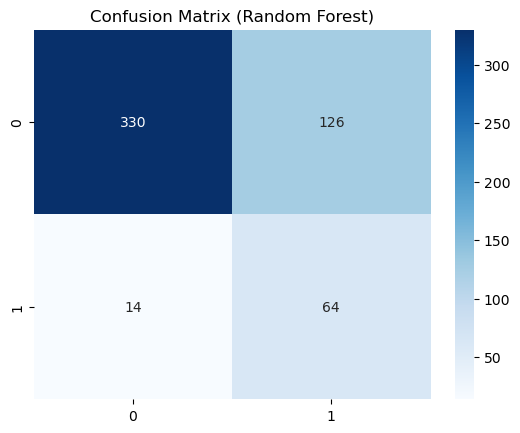

In [313]:
# Random Forest 검증 데이터 평가
y_prob_rf = rf_model.predict_proba(X_valid)[:, 1]
y_pred_rf = (y_prob_rf >= 0.3).astype(int)

print(classification_report(y_valid, y_pred_rf))

# Confusion Matrix 분석
cm_rf = confusion_matrix(y_valid, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.show()

=== Random Forest (threshold=0.3) ===
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       456
           1       0.34      0.82      0.48        78

    accuracy                           0.74       534
   macro avg       0.65      0.77      0.65       534
weighted avg       0.87      0.74      0.77       534



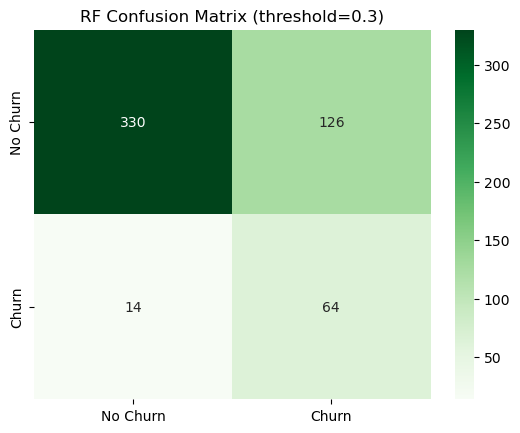

In [314]:
# 예측 확률 계산 (Churn=1)
y_prob = rf_model.predict_proba(X_valid)[:, 1]

# threshold 재설정
threshold = 0.3
y_pred_rf_03 = (y_prob_rf >= threshold).astype(int)

print("=== Random Forest (threshold=0.3) ===")
print(classification_report(y_valid, y_pred_rf_03))

# Confusion Matrix 출력
cm_rf_03 = confusion_matrix(y_valid, y_pred_rf_03)

sns.heatmap(
    cm_rf_03,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.title("RF Confusion Matrix (threshold=0.3)")
plt.show()

### 오분류 케이스 분석

In [320]:
# index를 유지해서 어떤 고객이 틀렸는지 추적
valid_result = X_valid.copy()
valid_result["y_true"] = y_valid.values
valid_result["y_pred"] = y_pred_rf
valid_result["y_prob"] = y_prob_rf

# False Positive: 실제 0인데 1로 예측
fp = valid_result[(valid_result["y_true"] == 0) & (valid_result["y_pred"] == 1)]

# False Negative: 실제 1인데 0으로 예측 (이탈 놓침)
fn = valid_result[(valid_result["y_true"] == 1) & (valid_result["y_pred"] == 0)]

print("FP count:", len(fp))
print("FN count:", len(fn))

# FP/FN 상위 몇 개 샘플 확인 (확률이 높은 순/낮은 순 등)
fp.sort_values("y_prob", ascending=False).head(10)

fn.sort_values("y_prob", ascending=False).head(10)

FP count: 126
FN count: 14


,International plan,Total day minutes,Total intl minutes,Customer service calls,y_true,y_pred,y_prob
1069,0,217.8,10.3,1,1,0,0.237819
1145,0,174.0,14.1,2,1,0,0.171248
1003,0,112.2,13.9,0,1,0,0.159979
883,0,189.1,10.4,1,1,0,0.154322
2159,0,144.8,13.3,0,1,0,0.152518
2306,0,90.0,8.6,2,1,0,0.148977
82,0,212.1,5.3,1,1,0,0.148953
2352,0,163.4,11.6,2,1,0,0.148506
2213,0,105.0,10.2,2,1,0,0.148468
984,0,186.4,11.1,2,1,0,0.143298


In [321]:
# 주요 변수 평균 비교 (FP/FN이 어떤 성향인지 빠르게 파악)
compare_cols = features

summary = pd.DataFrame({
    "Valid_mean": X_valid[compare_cols].mean(),
    "FP_mean": fp[compare_cols].mean(),
    "FN_mean": fn[compare_cols].mean()
})

summary

,Valid_mean,FP_mean,FN_mean
International plan,0.110487,0.293651,0.000000
Total day minutes,179.153933,222.128571,162.364286
Total intl minutes,10.271536,10.280952,10.121429
Customer service calls,1.529963,2.000000,1.357143


FP 고객은 국제 요금제를 쓰고, 통화량도 많고, 문의도 좀 있는 고객
FN 고객은 불만도 없고, 사용량도 평범해 보였던 고객

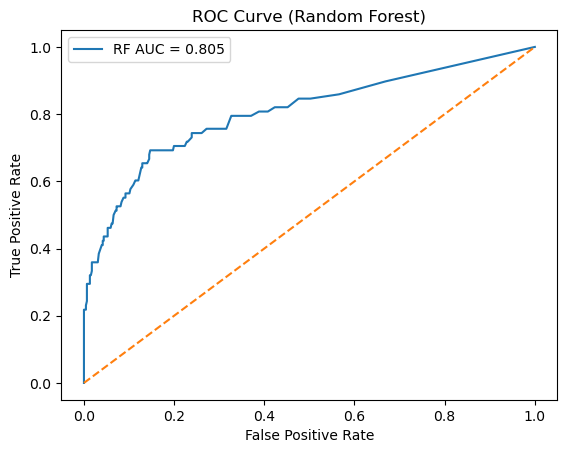

In [268]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_rf, tpr_rf, _ = roc_curve(y_valid, y_prob_rf)
auc_rf = roc_auc_score(y_valid, y_prob_rf)

plt.plot(fpr_rf, tpr_rf, label=f"RF AUC = {auc_rf:.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()

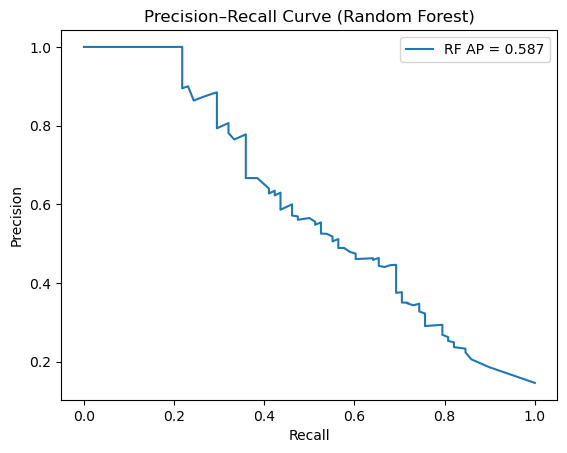

In [245]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_rf, recall_rf, _ = precision_recall_curve(y_valid, y_prob_rf)
ap_rf = average_precision_score(y_valid, y_prob_rf)

plt.plot(recall_rf, precision_rf, label=f"RF AP = {ap_rf:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.legend()
plt.show()

### 교차 검증
Stratified K-Fold 교차 검증을 통해
Random Forest 모델의 일반화 성능을 확인한다.

In [315]:
# 교차 검증 K-Fold CV 수행
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recall_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=skf,
    scoring="recall"
)

print("Recall mean:", recall_scores.mean())
print("Recall std :", recall_scores.std())

Recall mean: 0.7629370629370629
Recall std : 0.038273662394719965


과적합 여부와 안정성을 확인하기 위해서 Random Forest 모델 K-Fold 교차 검증 수행

### 최종 데이터 성능 평가
최종 테스트 데이터로 모델 성능을 평가하여 일반화 성능을 확인한다.

=== Final Test Performance (Random Forest) ===
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       572
           1       0.36      0.87      0.51        95

    accuracy                           0.76       667
   macro avg       0.67      0.81      0.68       667
weighted avg       0.89      0.76      0.79       667



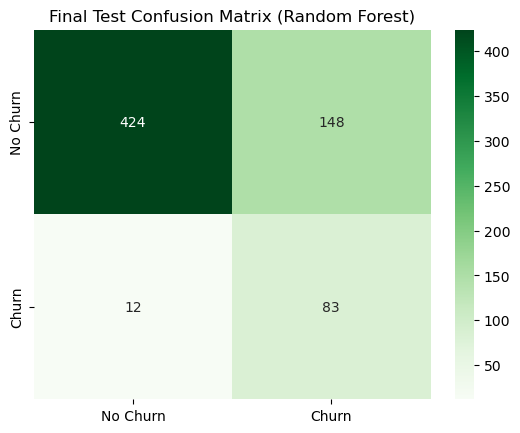

In [316]:
# 1. Test 데이터 준비
X_test = test[features]
y_test = test["Churn"]

# 2. 예측 확률
y_test_prob = rf_model.predict_proba(X_test)[:, 1]

# 3. 기존에 정한 threshold 그대로 사용
threshold = 0.3
y_test_pred = (y_test_prob >= threshold).astype(int)

# 4. 성능 평가
from sklearn.metrics import classification_report, confusion_matrix

print("=== Final Test Performance (Random Forest) ===")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=["No Churn", "Churn"],
    yticklabels=["No Churn", "Churn"]
)
plt.title("Final Test Confusion Matrix (Random Forest)")
plt.show()

## 6. 비즈니스 인사이트 액션 플랜
본 분석에서는 통신사 고객 이탈 데이터를 활용하여 고객 이탈의 주요 원인을 규명하고, 이를 기반으로 실행 가능한 비즈니스 전략을 도출하였다.

### 6.1 Key Findings Summary

#### 1) 이탈은 무작위가 아닌, 명확한 행동 신호의 누적으로 발생한다
EDA 및 모델 분석 결과,
고객 이탈은 특정 행동 및 사용 패턴과 강하게 연관되어 있음을 확인하였다.
특히 통화 사용량 증가, 고객센터 문의 누적,
그리고 국제 요금제 가입 여부는 이탈과 밀접한 관련을 보였다.

#### 2) 이탈 주요 원인 정리
모델 해석 결과를 종합하면,
이탈의 주요 원인은 다음 세 가지로 요약된다.

- 고사용량에 따른 요금 부담 증가
- 고객센터 문의 누적에 따른 불만 심화
- International plan과 같은 구조적 요금 리스크

#### 3) 고위험 고객 세그먼트 정의
Random Forest 모델 및 임계값 조정(threshold=0.3)을 통해
다음과 같은 고위험 고객군을 정의할 수 있었다.

- 일일 통화 사용량이 평균 대비 높은 고객
- 고객센터 문의 횟수가 3회 이상 누적된 고객
- International plan 가입 고객

해당 세그먼트는 실제 이탈 고객의 상당 부분을 포함하고 있으며,
모델이 안정적으로 탐지할 수 있는 영역으로 판단된다.

#### 4) 예상 이탈률 및 모델 예측 신뢰도
전체 고객 중 약 14.5%가 실제 이탈 고객으로 확인되었으며,
Random Forest 모델은 임계값 조정 후
검증 데이터 기준 약 82%,
최종 테스트 데이터 기준 약 87%의 이탈 고객 recall을 기록하였다.

이는 모델이 실제 이탈 고객을 놓치지 않고
안정적으로 탐지할 수 있는 수준의 신뢰도를 보유하고 있음을 의미한다.

### 6.2 Actionable Business Strategies

모델 분석 결과를 기반으로,
이탈 방지를 위한 실행 가능한 전략을 다음과 같이 제안한다.

**전략 1: 고객센터 문의 기반 조기 경고 시스템**
- 고객센터 문의 횟수가 3회 이상 누적된 고객을 이탈 위험 고객으로 자동 분류
- 4회차 문의 이전에 전담 상담사 배정 및 요금/서비스 점검 수행
- 불만 유형 태깅을 통해 반복 이슈 사전 차단

**기대 효과**
- 불만 누적에 따른 이탈을 사전에 차단
- 상대적으로 저비용으로 높은 이탈 방지 효과 기대

**전략 2: International Plan 고객 선제 관리**
- International plan 가입 고객을 구조적 리스크 고객군으로 정의
- 가입 초기(1~3개월) 사용량 및 요금 패턴 모니터링 강화
- 해외 통화 요금 사전 안내 및 대체 요금제 추천 제공

**기대 효과**
- 요금 충격에 의한 돌발 이탈 방지
- 고가치 고객의 장기 유지 가능

**전략 3: 고사용량 고객 맞춤 요금제 제안**
- 일일 통화 사용량이 높은 고객을 요금 민감 고객군으로 분류
- 사용 패턴 대비 요금 부담이 높은 고객에게 상위 요금제 또는 할인 옵션 제안

**기대 효과**
- 이탈 방지와 동시에 ARPU(가입자당 평균 매출) 증대 가능

**전략 4: 고사용량 고객 맞춤 요금제 제안**
- 임계값(threshold=0.3)을 기준으로 이탈 위험 고객을 선별
- 이탈 확률이 높은 고객에게는 적극적 리텐션 액션 제공
- 낮은 확률 고객에게는 저비용 알림/안내 중심 대응

**기대 효과**
- 이탈 고객을 놓치는 비용(FN)을 최소화
- 제한된 리소스를 가장 위험한 고객군에 집중 투입

### 6.3 ROI 관점 종합 정리
본 분석에서 제안한 전략은 이탈 고객을 사전에 탐지하여 고객 이탈로 인한 매출 손실을 줄이는 것을 목표로 한다.

False Positive 고객에 대한 대응 비용은
False Negative 고객(이탈 고객)을 놓쳤을 때 발생하는
매출 손실 대비 상대적으로 낮은 수준으로,
일부 오탐을 감수하더라도
전체적인 ROI는 개선될 것으로 판단된다.

### 6.4 결론
본 프로젝트를 통해 고객 이탈은
무작위적 현상이 아닌 예측 가능한 행동 패턴의 결과임을 확인하였다.
Random Forest 모델과 임계값 전략을 결합함으로써
이탈 고객을 효과적으로 조기 탐지할 수 있으며,
이를 기반으로 한 선제적 개입은
비즈니스 관점에서 실질적인 가치 창출로 이어질 수 있다.